# Process lineage data for M2 tumors

## Purpose

This notebook processes MERFISH data from a lineage tracing experiment. It calls clones based on shared target sites and identifies doublets. It also processes target site spots, filtering out dim spots, removing target sites with multiple integrations, and finally assigning a unique target site allele to each cell.

## Setup

In [6]:
import multiprocessing as mp
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import petracer
import pycea as py
import seaborn as sns
import squidpy as sq
import treedata as td
from sklearn.decomposition import NMF

np.random.seed(42)

from petracer.config import discrete_cmap, edit_cmap, sequential_cmap, site_names

site_names = list(site_names.keys())
base_path, data_path, plot_path, results_path = petracer.config.get_paths("tumor_tracing")
petracer.config.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

Specify samples and names

In [7]:
samples = {"M2-1":Path("/lab/weissman_imaging/4T1/240915_F308-1_MF4")}

Transciptome

In [8]:
adata = ad.read_h5ad(data_path / "M2.h5ad")
adata.obs["type"] = (adata.obs.cell_subtype == "Malignant").map({True:"tracing", False:"non-tracing"})
adata.obs["type"] = pd.Categorical(adata.obs["type"],
       categories=["tracing", "non-tracing", "doublet", "low_detection", "low_umi", "high_mito"])

Lineage

In [10]:
alleles = []
for sample, path in samples.items():
    sample_alleles =  pd.read_csv(f"{path}/decoded_spots.csv",keep_default_na=False)
    sample_alleles["sample"] = sample
    sample_alleles["cellBC"] = (sample + "-" + sample_alleles["cell"].astype(str).values)
    alleles.append(sample_alleles)
alleles = pd.concat(alleles)
alleles = alleles[alleles["cellBC"].isin(adata.obs.cellBC)]
alleles.cell_dist = alleles.cell_dist.astype(float)
alleles.rename(columns={"intBC":"intID"},inplace=True)
alleles = alleles.merge(adata.obs[["cellBC","tumor"]],on="cellBC")

/tmp/ipykernel_51741/3399862974.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_alleles =  pd.read_csv(f"{path}/decoded_spots.csv",keep_default_na=False)


## Imaging statistics

Cells per sample

<Axes: xlabel='sample', ylabel='count'>

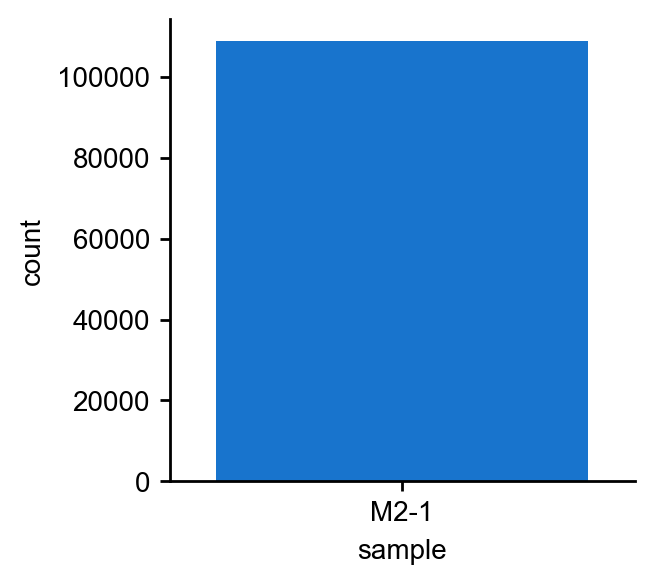

In [11]:
sns.countplot(data = adata.obs, x = "sample",hue = "sample",legend=False,saturation = 1)

intBC intensity vs distance

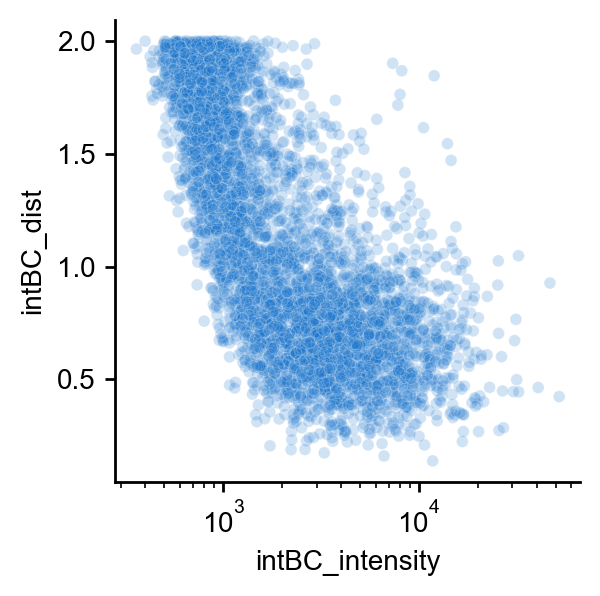

In [12]:
sns.scatterplot(data =alleles.sample(5000), x = "intBC_intensity", y = "intBC_dist",
                hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")

Alleles per cell

<Axes: xlabel='n_spots', ylabel='Count'>

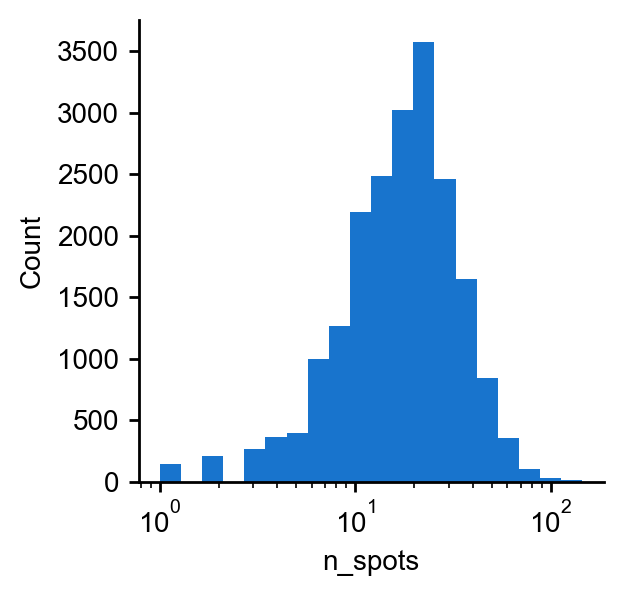

In [13]:
sns.histplot(data = alleles.groupby(["sample","cellBC"]).size().reset_index(name = "n_spots"), 
            x = "n_spots",hue = "sample",legend=False,multiple="stack",linewidth=0,bins = 20,alpha = 1,log_scale=True)

## Filter target site spots

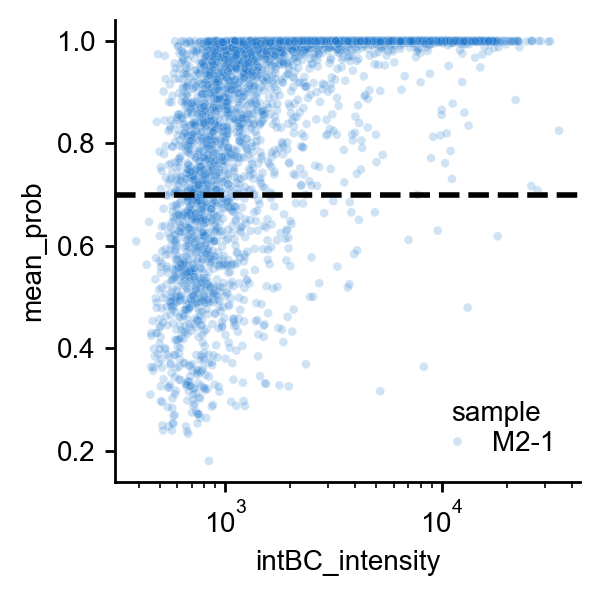

In [14]:
min_mean_prob = .7
alleles["mean_prob"] = alleles[["EMX1_prob","HEK3_prob","RNF2_prob"]].mean(axis = 1)
filtered_alleles = alleles.query("mean_prob > @min_mean_prob ").copy()
sns.scatterplot(data = alleles.sample(5000), x = "intBC_intensity", y = "mean_prob",hue = "sample",alpha = 0.2,s = 10)
plt.xscale("log")
plt.axhline(min_mean_prob, linestyle="--",color = "black")

## Identify clones

/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


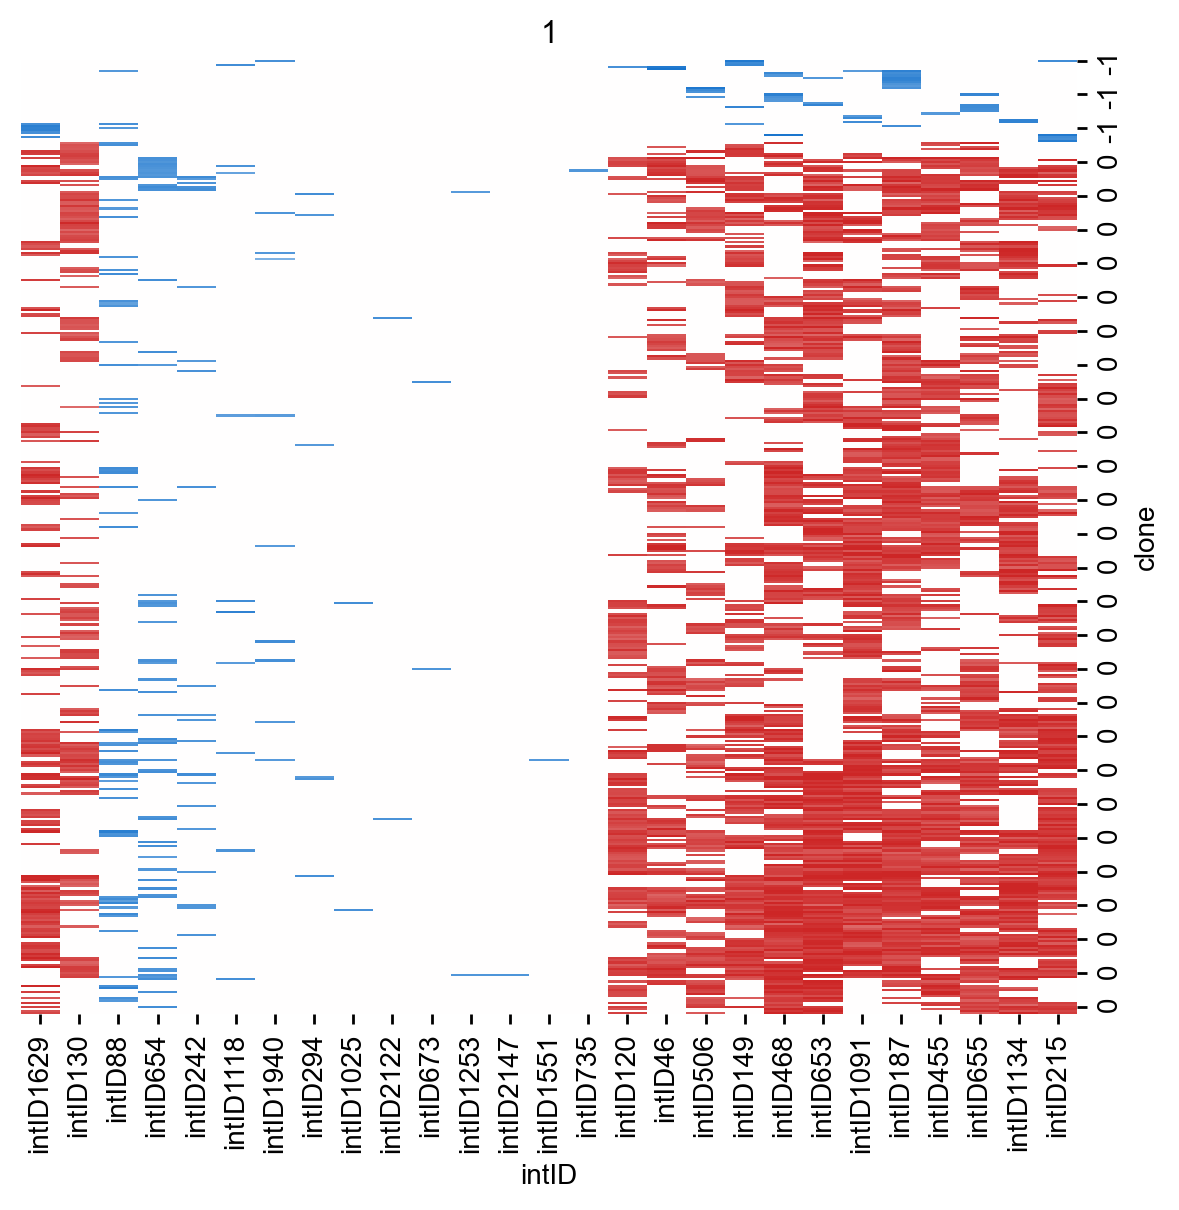

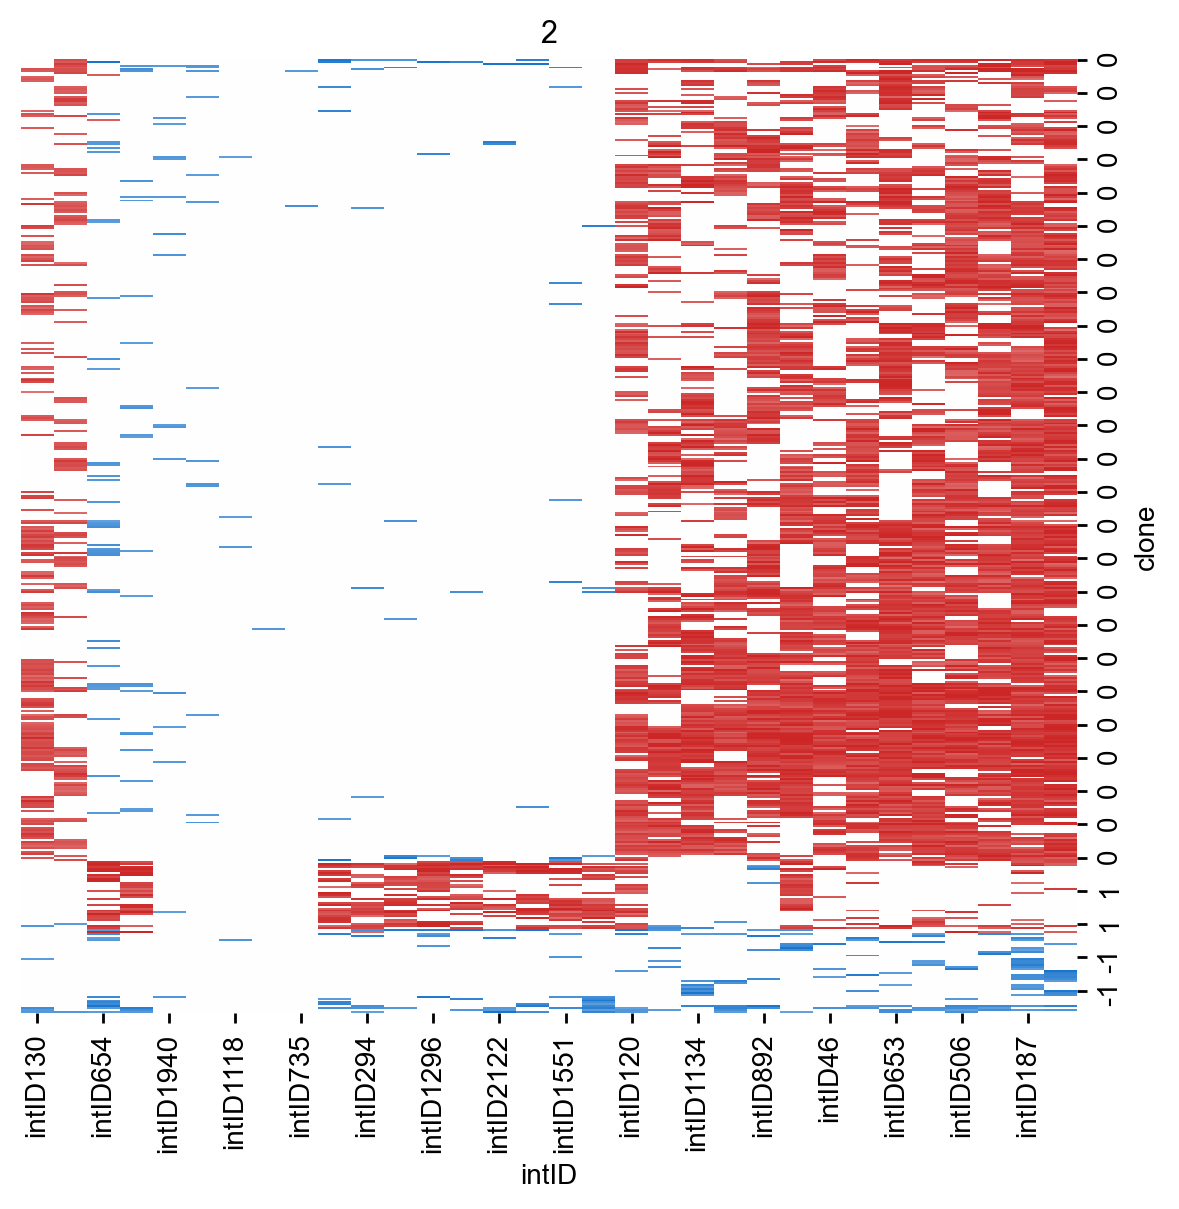

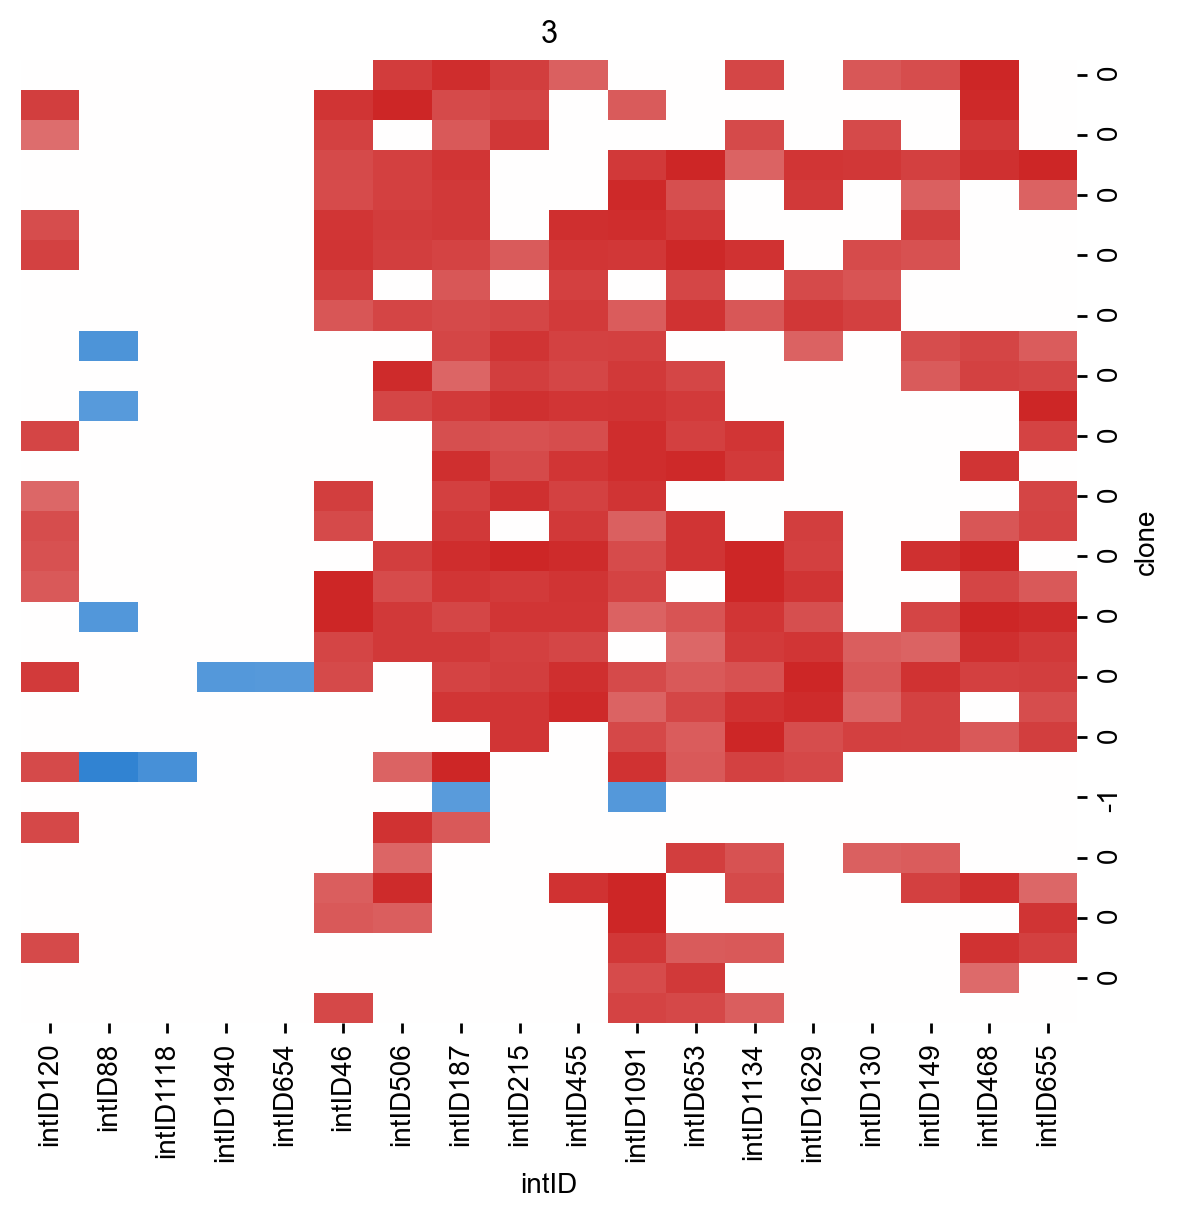

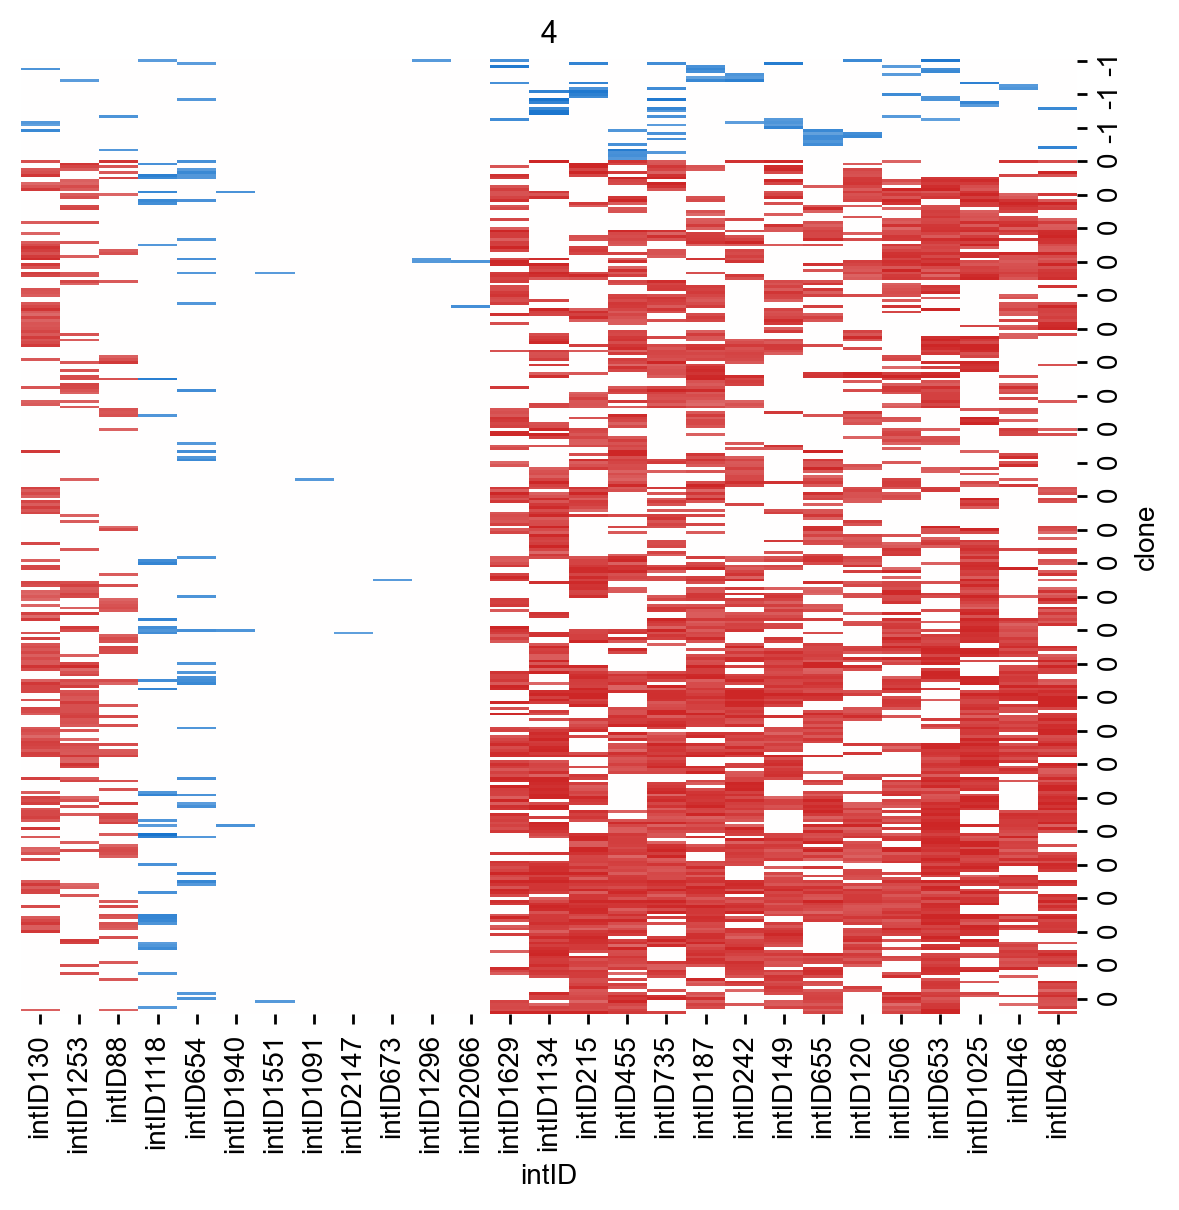

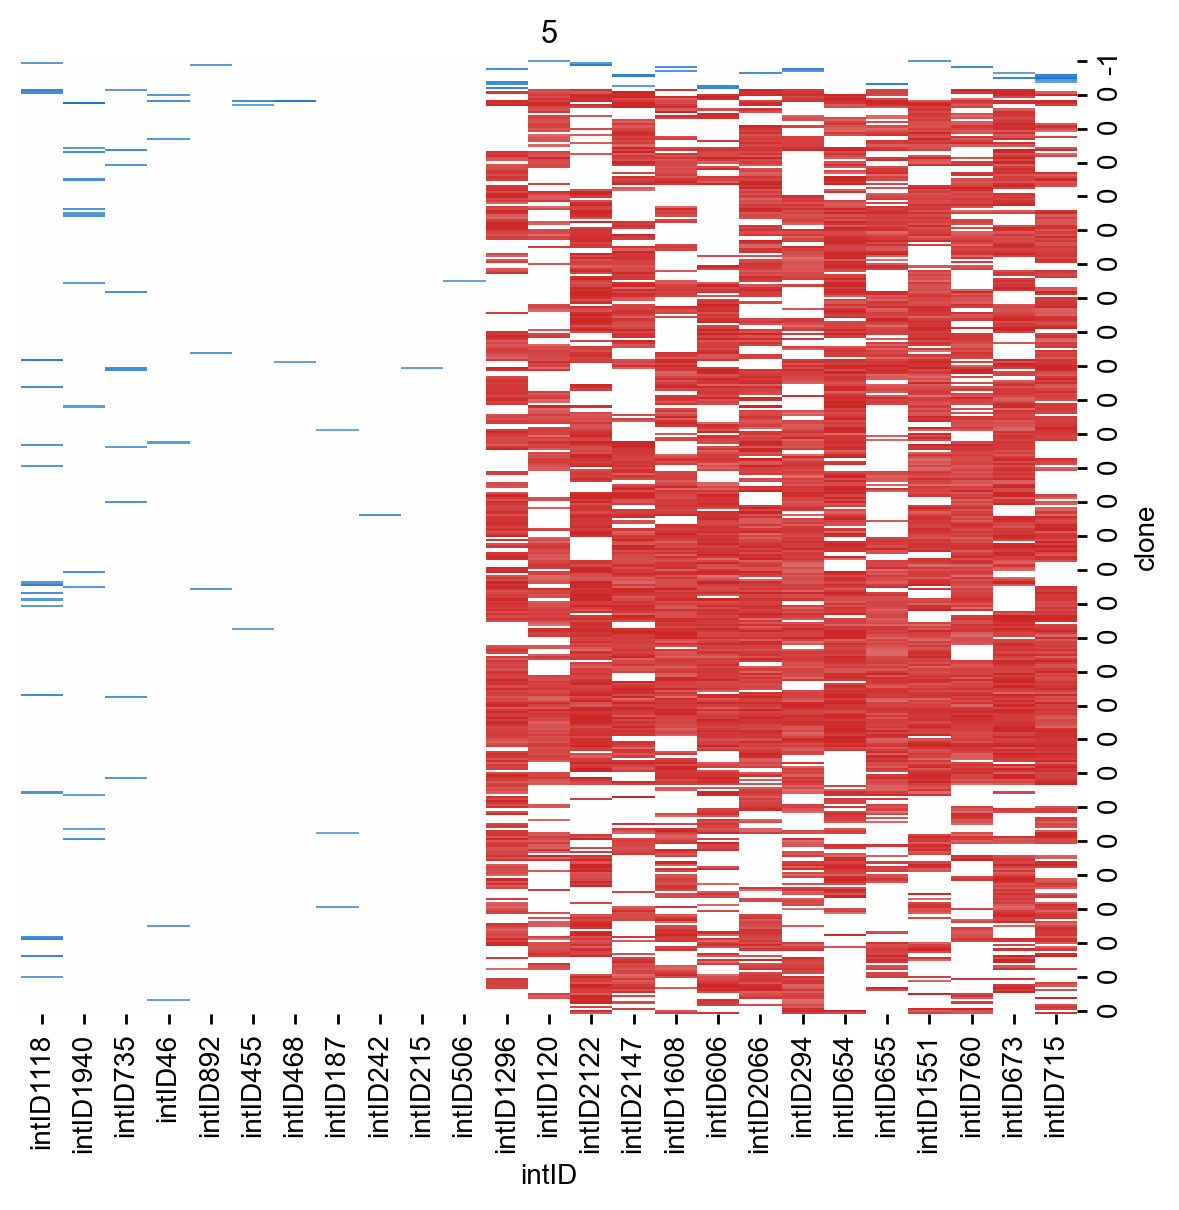

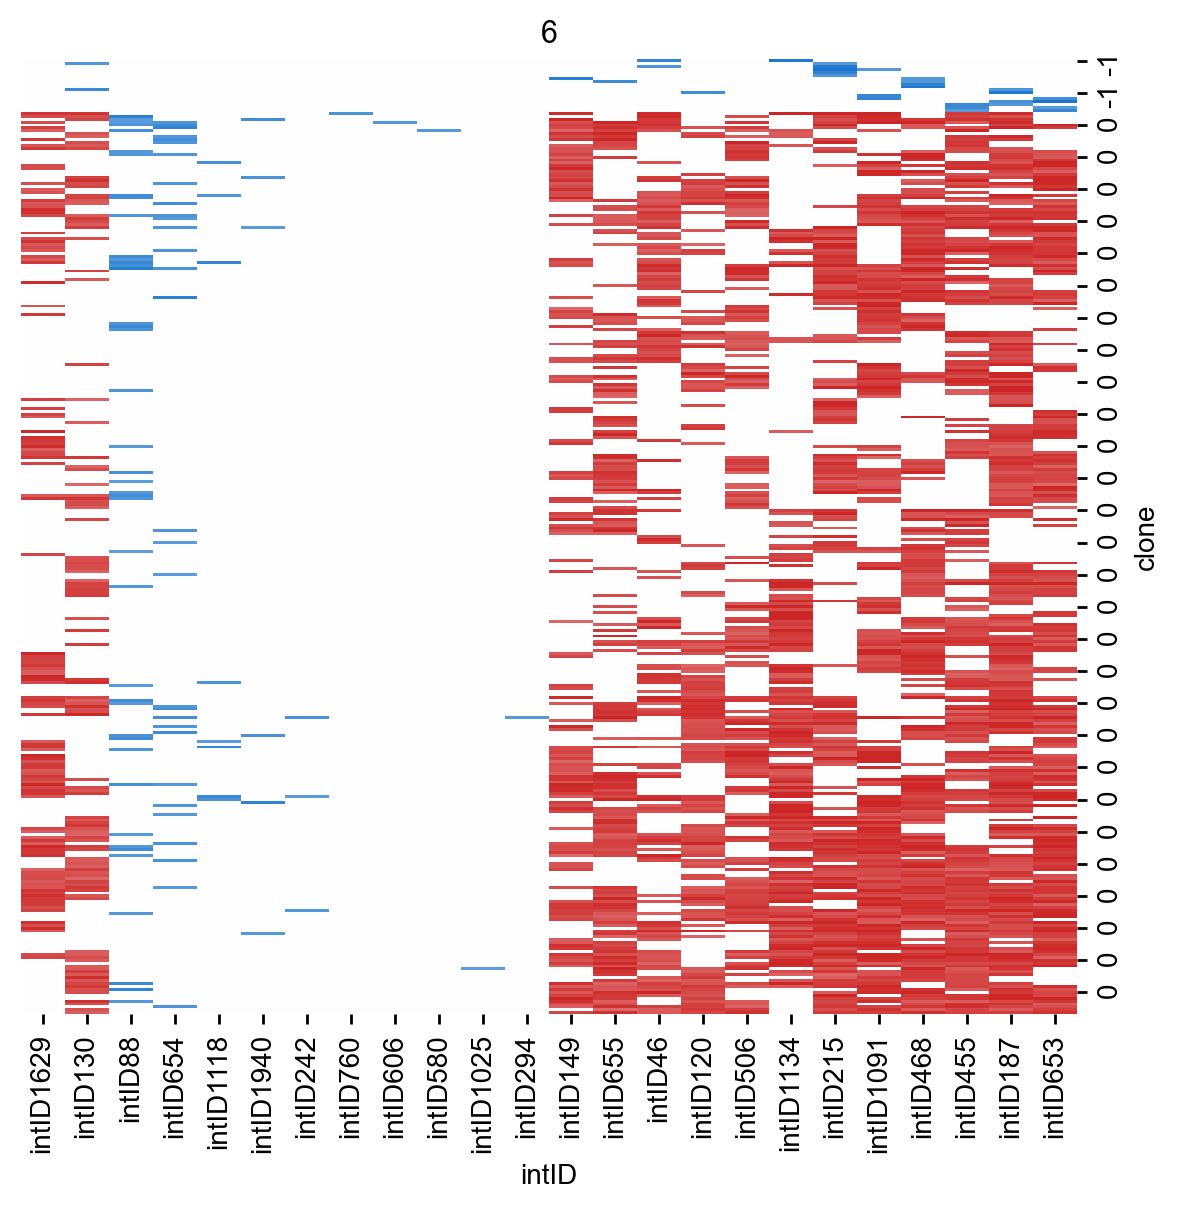

In [15]:
tumor_n_clones =  {"1":1,"2":2,"3":1,"4":1,"5":1,"6":1}
min_frac = .2
min_jaccard = .2
whitelist_alleles = []
cell_to_clone = []
for tumor, n_clones in tumor_n_clones.items():
    model = NMF(n_components=n_clones)
    sample_alleles, sample_clones = petracer.clones.call_clones(filtered_alleles.query("tumor == @tumor"),
                                                model,plot_title = tumor,min_frac=min_frac,min_jaccard=min_jaccard)
    whitelist_alleles.append(sample_alleles)
    cell_to_clone.append(sample_clones.assign(tumor = tumor))
whitelist_alleles = pd.concat(whitelist_alleles)
cell_to_clone = pd.concat(cell_to_clone)

Rename clones by size

In [16]:
clone_counts = cell_to_clone.query("whitelist").groupby(["tumor","clone"]).size().reset_index(name = "n").sort_values("n",ascending = False)
clone_counts["unique_clone"] = clone_counts.tumor.astype(str) + "-" + (clone_counts.clone.astype(int) + 1).astype(str)
clone_counts["tumor_n"] = clone_counts["tumor"].map(tumor_n_clones)
clone_counts.loc[clone_counts["tumor_n"] == 1,"unique_clone"] = clone_counts["tumor"]
clone_counts

,tumor,clone,n,unique_clone,tumor_n
1,2,0,11629,2-1,2
5,5,0,2746,5,1
0,1,0,2403,1,1
2,2,1,1061,2-2,2
4,4,0,626,4,1
6,6,0,497,6,1
3,3,0,31,3,1


Add clone to cells and alleles

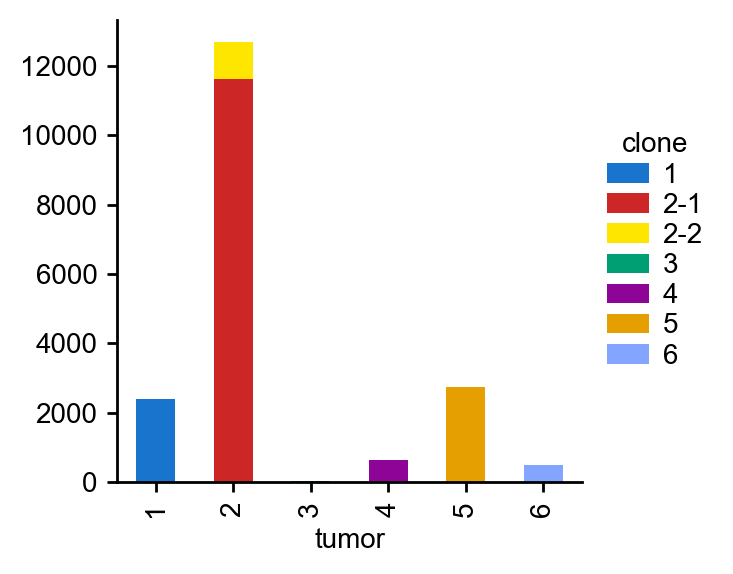

In [17]:
cell_to_clone = cell_to_clone.merge(clone_counts[["tumor","clone","unique_clone"]], on = ["tumor","clone"], how = "left")
filtered_alleles = whitelist_alleles.copy()
filtered_alleles["clone"] = filtered_alleles["cellBC"].map(cell_to_clone.set_index("cellBC")["unique_clone"])
adata.obs["clone"] = adata.obs["cellBC"].map(cell_to_clone.set_index("cellBC")["unique_clone"])
adata.obs.groupby(['tumor', 'clone'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='clone', bbox_to_anchor=(1, 0.5))

Spatial organization of clones

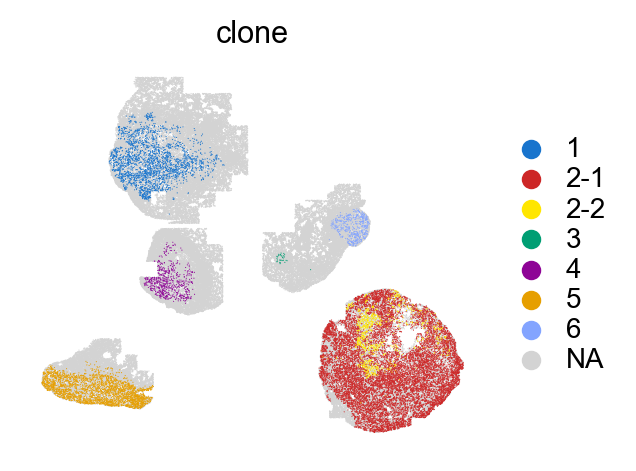

In [18]:
sc.pl.spatial(adata, color = "clone", spot_size = 15,frameon=False)

Mark doublets and unassigned cells

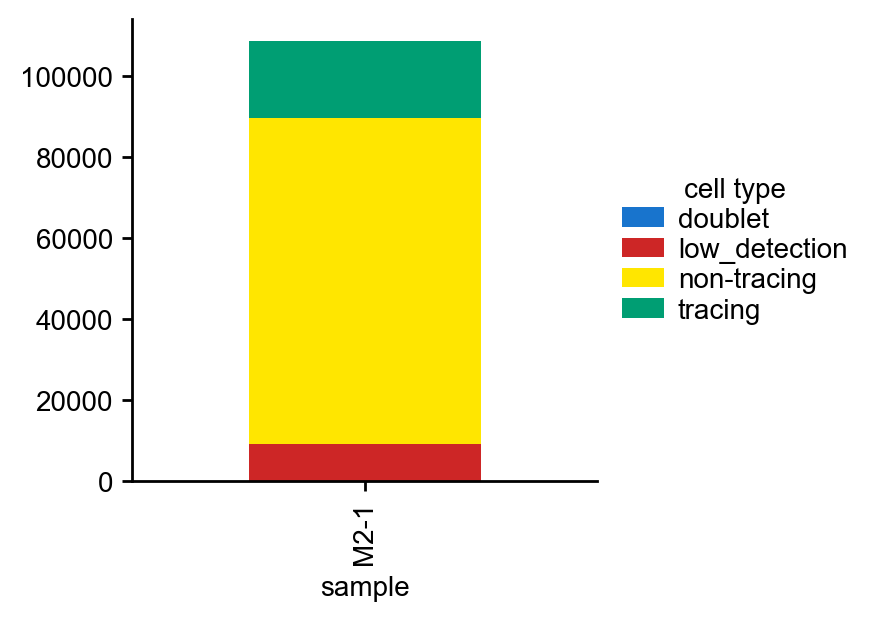

In [19]:
doublets = cell_to_clone.query("clone.str.contains(',')")["cellBC"]
adata.obs["type"] = adata.obs["type"].astype("str")
adata.obs.loc[doublets, "type"] = "doublet"
adata.obs["type"] = adata.obs["type"].astype("str")
adata.obs.loc[(adata.obs["type"] == "tracing") & adata.obs.clone.isna(), "type"] = "low_detection"
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Filter alleles

Select brightest spot within the nucleus for each allele

In [20]:
filtered_alleles["in_nucleus"] = filtered_alleles["cell_dist"] == 0
filtered_alleles = filtered_alleles.sort_values(["in_nucleus","intBC_intensity"],ascending = False).groupby(
    ["cellBC","intID","HEK3","EMX1","RNF2"]).first().reset_index()
filtered_alleles["n_alleles"] = filtered_alleles.groupby(["clone","cellBC","intID"]).intID.transform("count")

Remove integrations with conflicts in >30% of cells

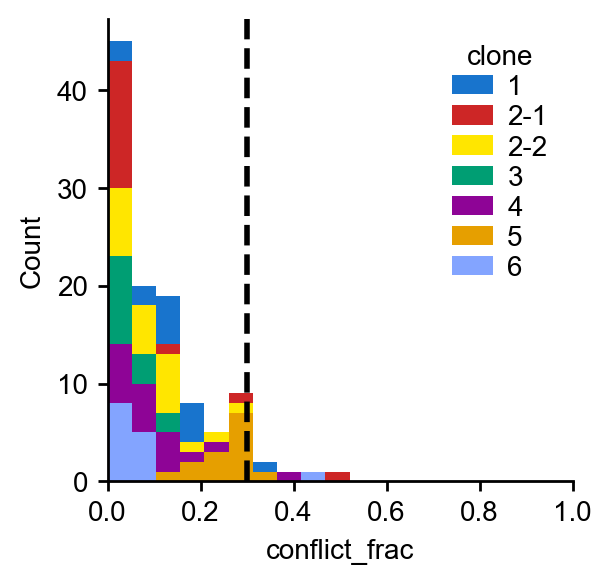

In [21]:
max_int_conflict = .3
int_conflicts = filtered_alleles.query("whitelist").groupby(["clone","cellBC","intID"]).agg({"n_alleles":"first"}).reset_index()
int_conflicts["conflict"] = int_conflicts["n_alleles"] > 1
int_conflicts = int_conflicts.groupby(["clone","intID"]).agg({"conflict":"mean"}).reset_index().rename(columns = {"conflict":"conflict_frac"})
filtered_alleles = filtered_alleles.merge(int_conflicts, on = ["clone","intID"]).query(
    "conflict_frac < @max_int_conflict").copy().drop(columns = "conflict_frac")
sns.histplot(int_conflicts, x = "conflict_frac",bins = 10,hue = "clone",multiple="stack",linewidth=0,alpha = 1)
plt.axvline(x=max_int_conflict, color="black", linestyle="--")
plt.xlim(0,1);

Mark cells with conflict in > 50% of alleles as doublets

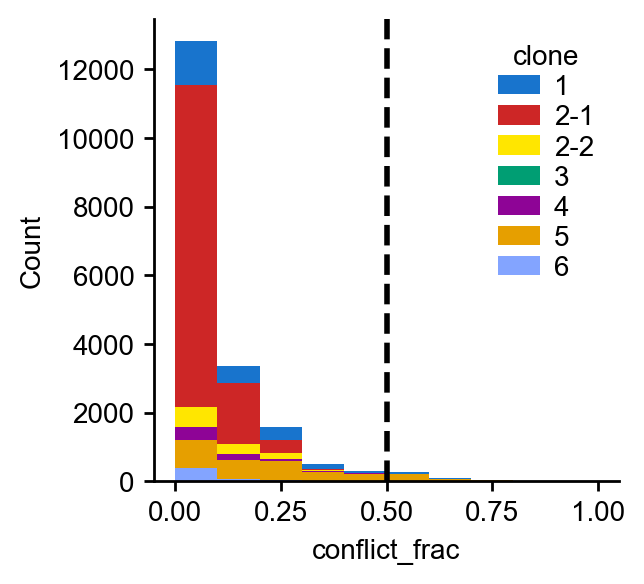

In [22]:
max_cell_conflict = .50
cell_conflicts = filtered_alleles.query("whitelist").groupby(["clone","cellBC","intID"]).agg({"n_alleles":"first"}).reset_index()
cell_conflicts["conflict"] = cell_conflicts["n_alleles"] > 1
cell_conflicts = cell_conflicts.groupby(["clone","cellBC"]).agg({"conflict":"mean"}).reset_index().rename(columns = {"conflict":"conflict_frac"})
doublets = cell_conflicts.query("conflict_frac > @max_cell_conflict")["cellBC"]
sns.histplot(cell_conflicts, x = "conflict_frac",bins = 10,hue = "clone",multiple="stack",linewidth=0,alpha = 1)
plt.axvline(x=max_cell_conflict, color="black", linestyle="--")

Resolve remaining conflict by selecting the brightest spot

In [23]:
filtered_alleles = filtered_alleles[~filtered_alleles.cellBC.isin(doublets)].copy()
filtered_alleles = filtered_alleles.sort_values("intBC_intensity",ascending = False).groupby(
    ["intID","cellBC"]).first().reset_index().drop(columns = ["n_alleles","in_nucleus"])

Mark doublets

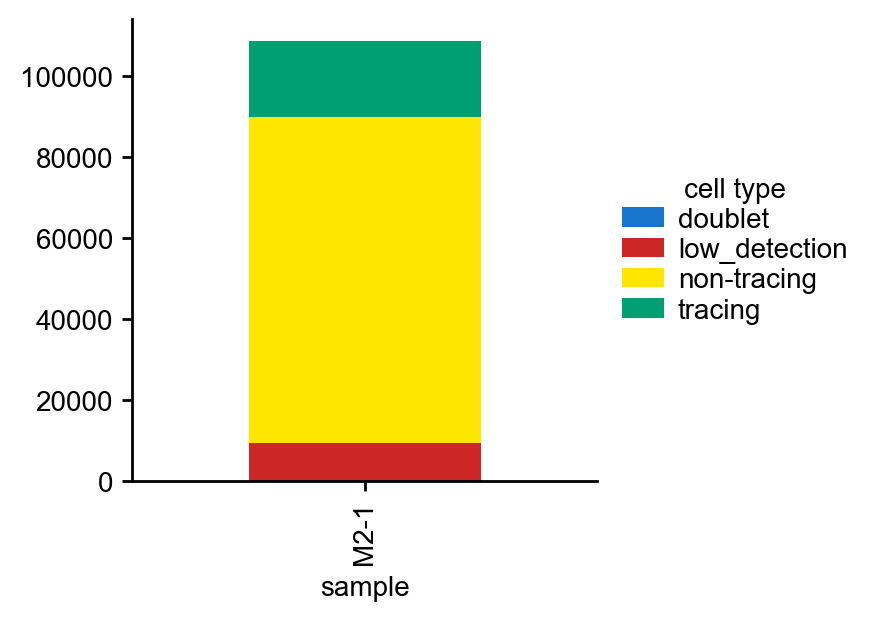

In [24]:
adata.obs.loc[(adata.obs["type"] == "tracing") & (adata.obs.cellBC.isin(doublets)), "type"] = "doublet"
adata.obs.loc[adata.obs["type"] != "tracing", "clone"] = None
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Allele statistics

In [25]:
tracing_cells = adata.obs.query("type == 'tracing'").index
filtered_alleles = filtered_alleles.query("cellBC.isin(@tracing_cells)").copy()

Edit probability vs brightness

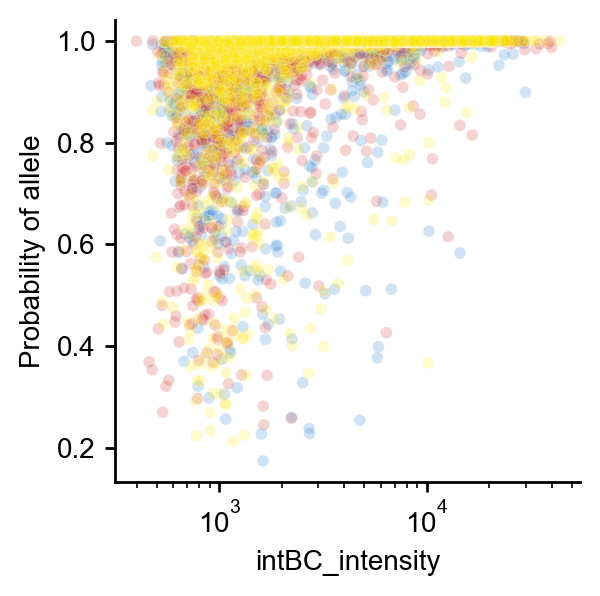

In [26]:
fig, ax = plt.subplots()
for i, site in enumerate(site_names):
    sns.scatterplot(filtered_alleles.sample(5000), x = "intBC_intensity", y = f"{site}_prob",
                    legend=False,alpha = 0.2,size = .1,ax = ax)
plt.xscale("log");
plt.ylabel("Probability of allele");

<Axes: xlabel='clone', ylabel='detection_rate'>

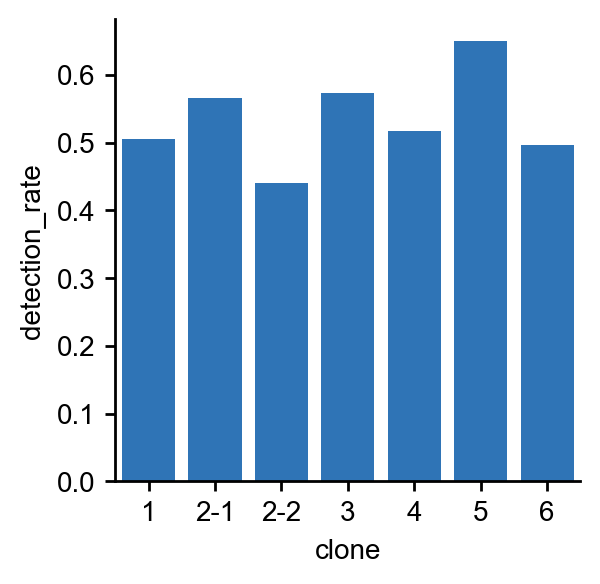

In [27]:
int_detection = (filtered_alleles.query("whitelist").groupby(["intID","clone","sample"]).size() / 
                 filtered_alleles.query("whitelist").groupby(["clone","sample"])["cellBC"].nunique())
int_detection = int_detection.reset_index(name = "detection_rate")
sns.barplot(data = int_detection.groupby(["clone"]).agg({"detection_rate":"mean"}).reset_index(),y = "detection_rate",x = "clone")

Detection rate per integration

<Axes: xlabel='clone', ylabel='intID'>

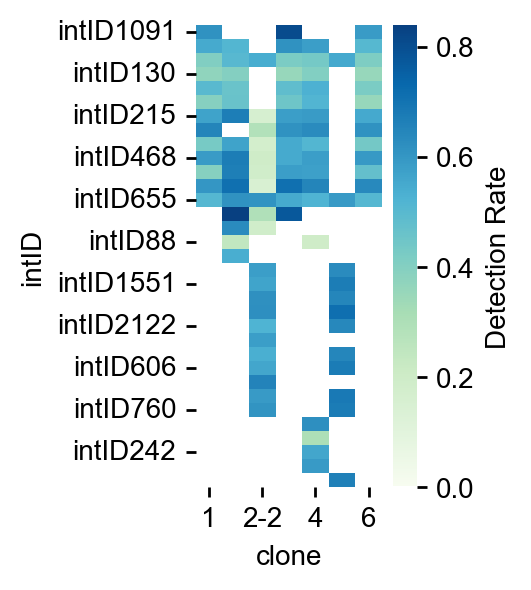

In [31]:
fig, ax = plt.subplots(figsize = (1.5,3))
int_order = int_detection.intID.drop_duplicates()
int_detection_wide = pd.pivot_table(int_detection,columns=["clone"], index=["intID"], values="detection_rate")
sns.heatmap(int_detection_wide.loc[int_order,:],cmap = sequential_cmap,vmin = 0,cbar_kws={"label":"Detection Rate"})

Detection rate per cell

<Axes: xlabel='detection_rate', ylabel='Count'>

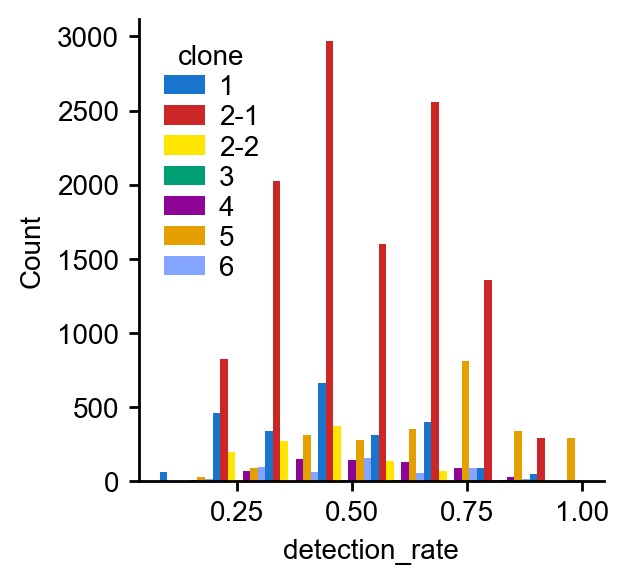

In [32]:
cell_detection = (filtered_alleles.query("whitelist").groupby(["clone","sample","cellBC"]).size() / 
                 filtered_alleles.query("whitelist").groupby(["clone","sample"])["intID"].nunique()).reset_index(name = "detection_rate")
adata.obs["detection_rate"] = adata.obs["cellBC"].map(cell_detection.set_index("cellBC")["detection_rate"])
sns.histplot(cell_detection, x = "detection_rate",bins = 8,hue = "clone",multiple="dodge",linewidth=0,alpha = 1)

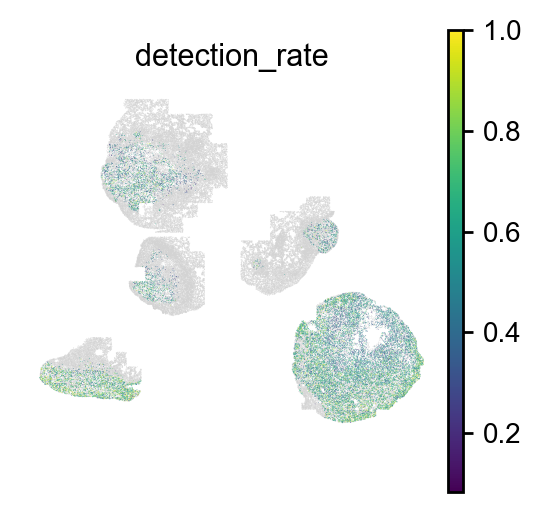

In [33]:
sc.pl.spatial(adata, color = "detection_rate", spot_size = 10,frameon=False)

Detection rate vs z position

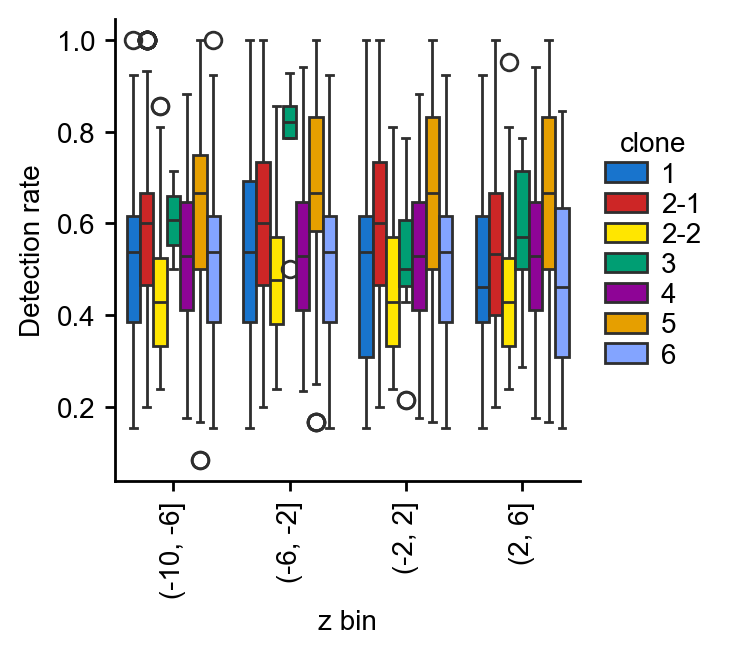

In [37]:
adata.obs["z_bin"] = pd.cut(adata.obs["centroid_z"], bins = np.arange(-10,10,4))
sns.boxplot(data = adata.obs.query("type == 'tracing' & volume < 10000"), x = "z_bin", y = "detection_rate",saturation=1,hue = "clone")
plt.xticks(rotation=90);
plt.xlabel("z bin");
plt.ylabel("Detection rate");
plt.legend(loc='center left', title='clone', bbox_to_anchor=(1, 0.5))
adata.obs.drop(columns = "z_bin",inplace = True)

Edit fraction

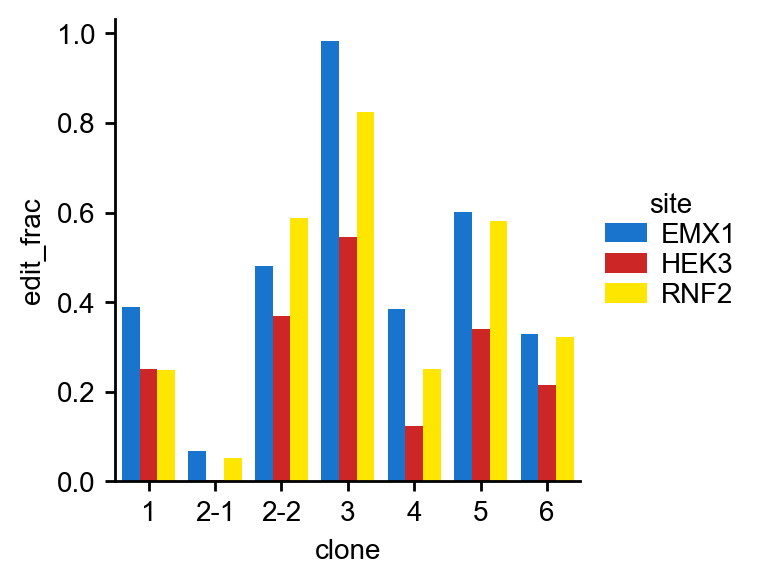

In [38]:
edit_counts = filtered_alleles.query("whitelist")[site_names + ["cellBC","intID","clone","sample"]].melt(
    id_vars = ["cellBC","intID","clone","sample"],value_name="edit", var_name="site")
edit_frac = edit_counts.query("edit != 'None'").groupby(["clone","sample","intID","site"]).size()/ \
    edit_counts.groupby(["clone","sample","intID","site"]).size()
edit_frac = edit_frac.reset_index(name = "edit_frac").groupby(["clone","site"]).agg({"edit_frac":"mean"}).reset_index()
sns.barplot(data = edit_frac,y = "edit_frac",x = "clone",hue = "site",saturation=1)
plt.legend(loc='center left', title='site', bbox_to_anchor=(1, 0.5))

Edit frequency

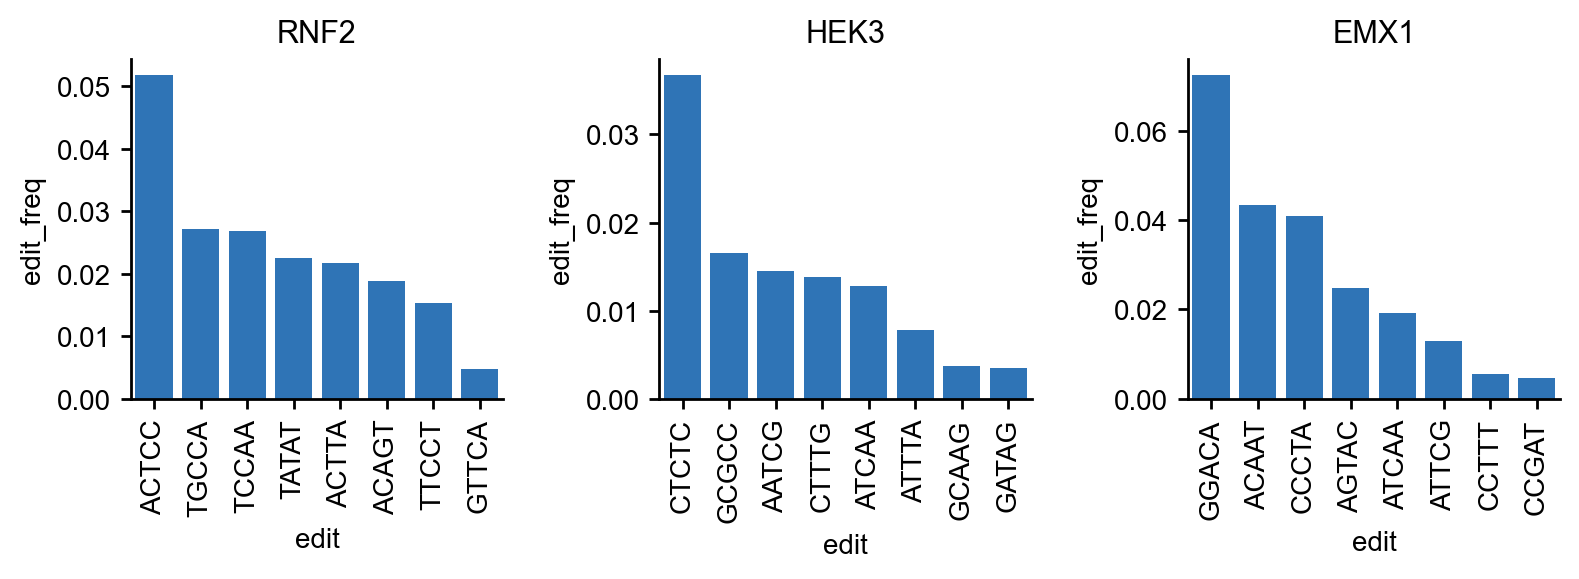

In [39]:
edit_frequency =  edit_counts.groupby(["site","edit"]).size() / edit_counts.groupby(["site"]).size()
edit_frequency = edit_frequency.reset_index(name = "edit_freq")

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for i, site in enumerate(site_names):
    sns.barplot(
        data=edit_frequency.query(f"site == '{site}' & edit != 'None'").sort_values("edit_freq", ascending=False).head(15),
        x="edit",y="edit_freq", ax=axes[i])
    axes[i].set_title(site)
    plt.setp(axes[i].get_xticklabels(), rotation=90)

plt.tight_layout()

## Reconstruct trees

In [73]:
def reconstruct_clone(clone):
    clone_tdata = td.TreeData(obs = adata.obs.query("clone == @clone & detection_rate >= .6"),allow_overlap = True)
    characters = petracer.tree.alleles_to_characters(filtered_alleles.query("whitelist & cellBC.isin(@clone_tdata.obs_names)"),min_prob=.7)
    clone_tdata.obsm["characters"] = characters.loc[clone_tdata.obs_names]
    key_characters = {"1":None,"2-1":None,"2-2":None,"3":None,"4":None,"5":['intID2066-RNF2'],"6":None}
    petracer.tree.reconstruct_tree(clone_tdata, solver = "nj",tree_added = "nj",estimate_lengths=False,collapse_edges = False,mask_truncal=True,upweight=key_characters[clone])
    py.pp.add_depth(clone_tdata,tree = "nj")
    return clone_tdata, clone

Reconstruct trees for all clone

In [74]:
with mp.Pool(processes=16) as pool:
    results = pool.map(reconstruct_clone, adata.obs["clone"].dropna().unique())
    clones = {clone:clone_tdata for clone_tdata, clone in results}

Plot trees

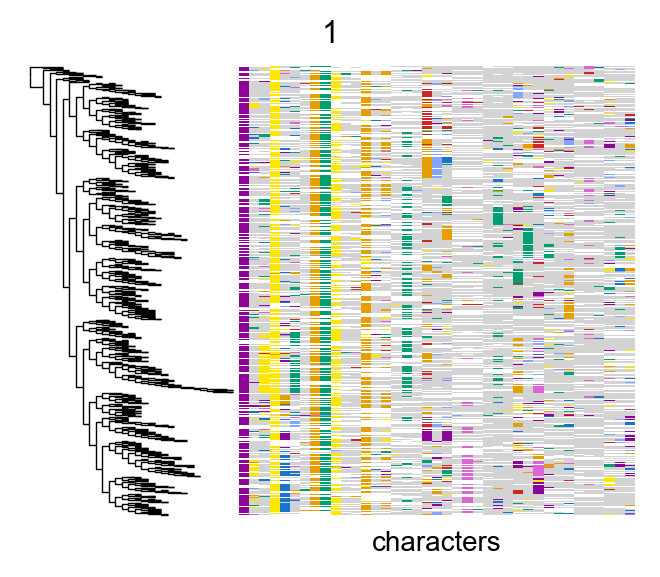

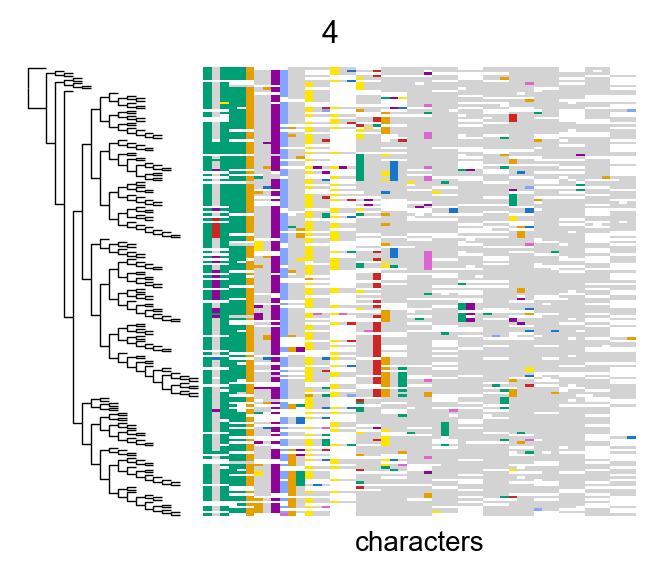

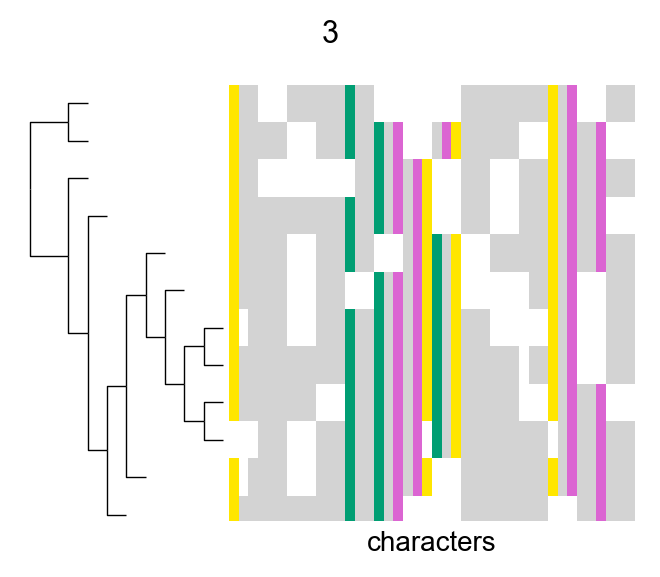

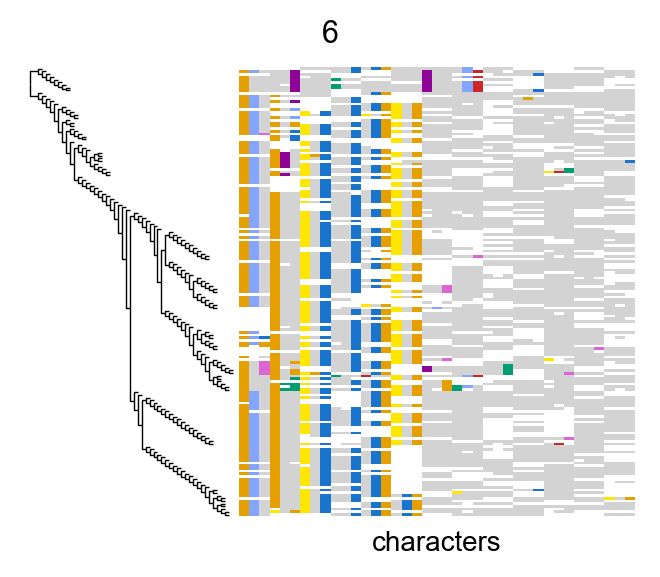

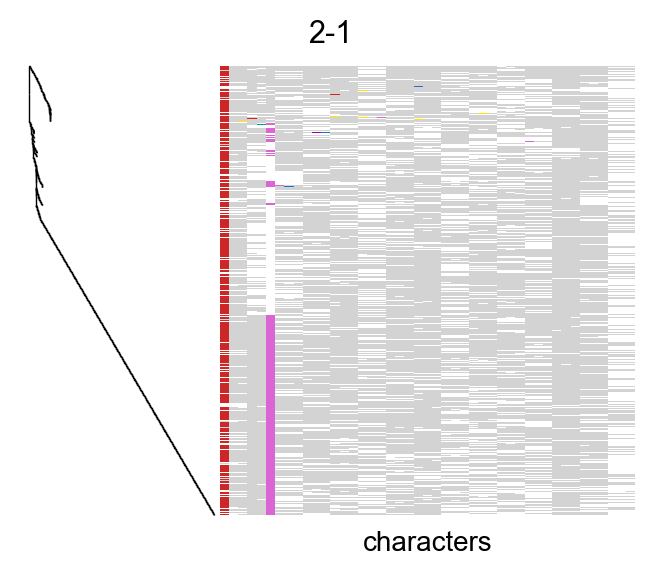

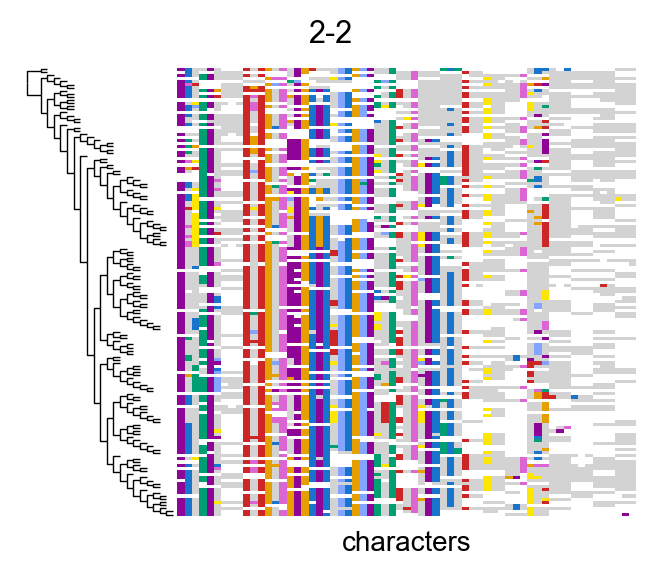

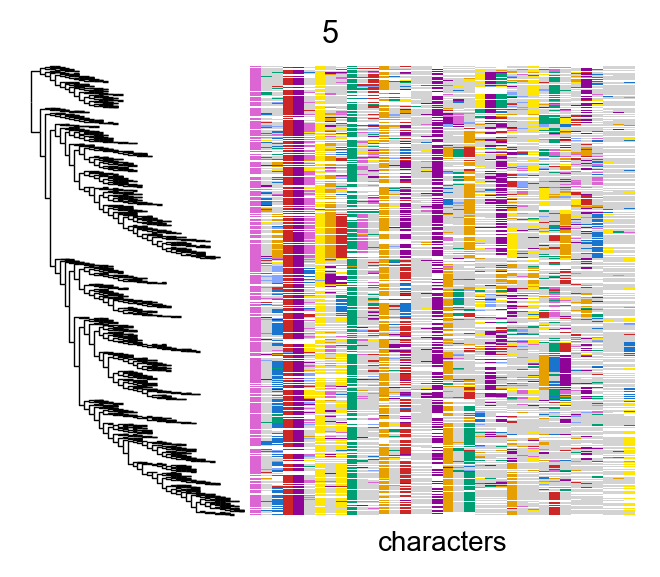

In [75]:
for clone, clone_tdata in clones.items():
    fig, ax = plt.subplots(figsize=(4, 3))
    py.pl.tree(clone_tdata,keys = "characters",cmap = edit_cmap,depth_key = "time",ax = ax)
    plt.title(clone)

Estimate branch lengths for clones with good tracing

In [76]:
total_time = 28
for clone in ["5"]:
    print("Estimating branch lengths for clone", clone)
    petracer.tree.estimate_branch_lengths(clones[clone], tree = "nj", copy = False)
    # rescale branch lengths to total time
    for node in clones[clone].obst["nj"].nodes:
        clones[clone].obst["nj"].nodes[node]['time'] = clones[clone].obst["nj"].nodes[node]['time'] * total_time

Estimating branch lengths for clone 5


/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Collapse mutationless edges

In [77]:
for clone, clone_tdata in clones.items():
    petracer.tree.identify_mutations(clone_tdata,tree = "nj")
    petracer.tree.collapse_mutationless_edges(clone_tdata,tree = "nj",tree_added="nj_collapsed",copy = False,mutation_key = "has_mutation")
    clone_tdata.obs["n_cells"] = 1
    py.tl.ancestral_states(clone_tdata,tree = "nj_collapsed",method = np.sum,keys = "n_cells")
    py.tl.sort(clone_tdata,key = "n_cells",tree = "nj_collapsed")
    py.pp.add_depth(clone_tdata,tree = "nj_collapsed")

Plot trees

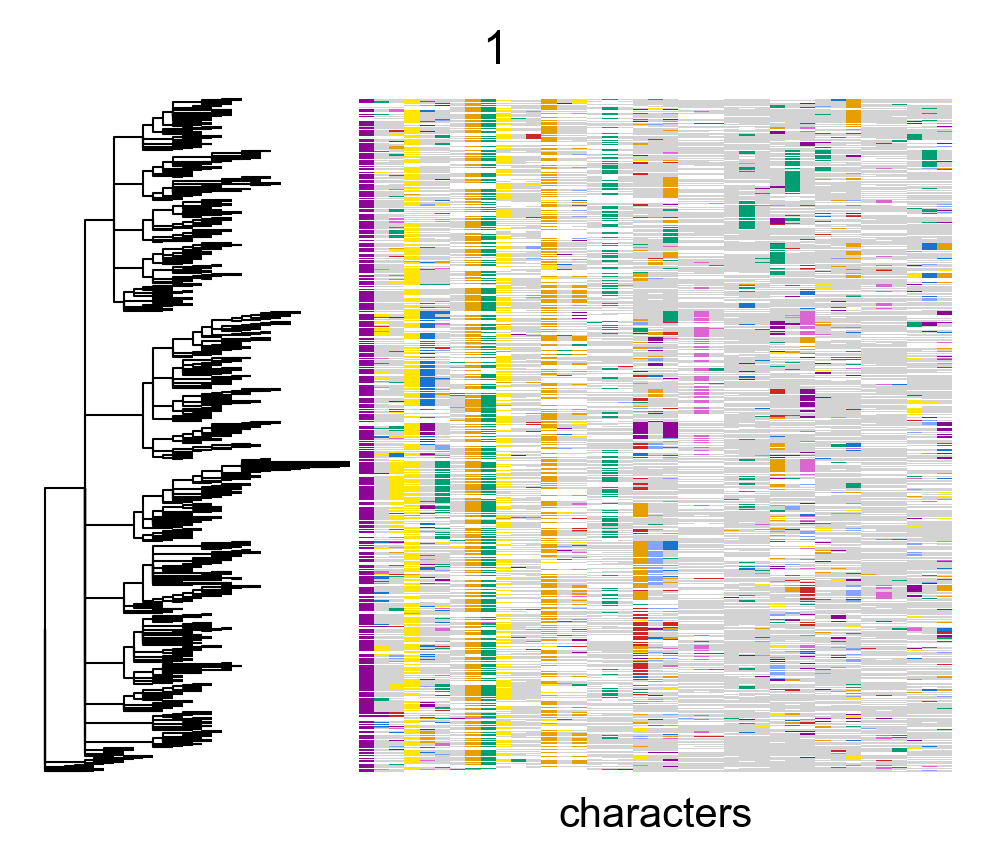

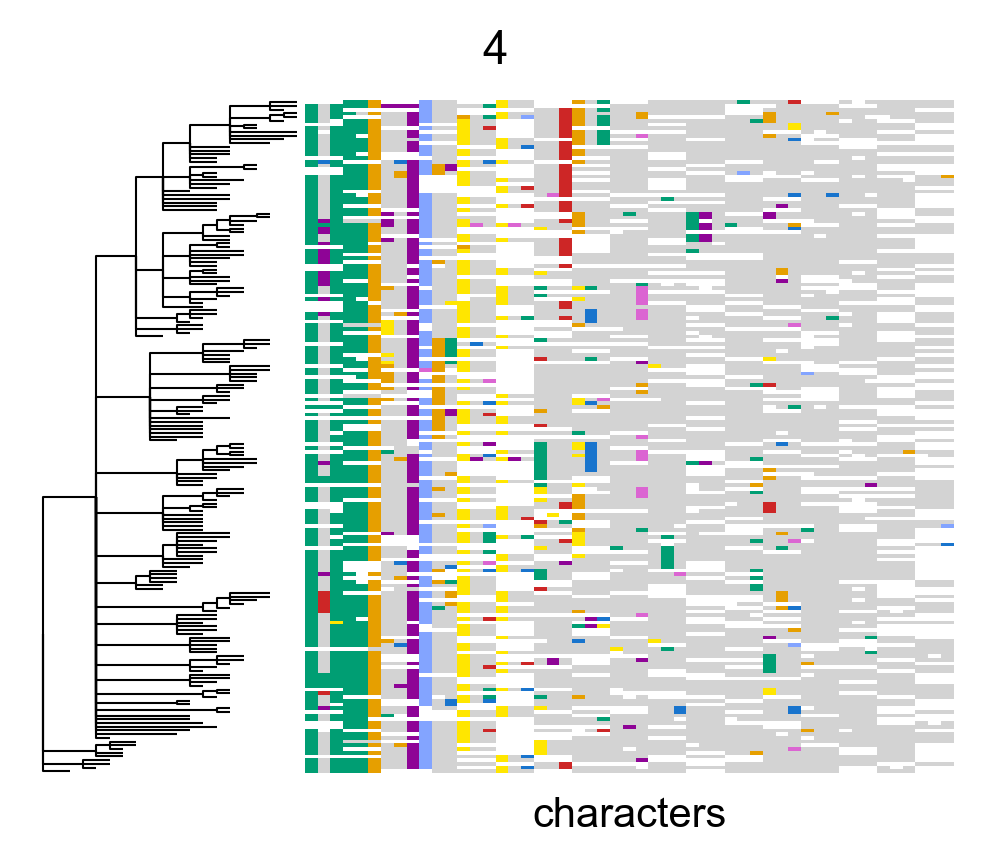

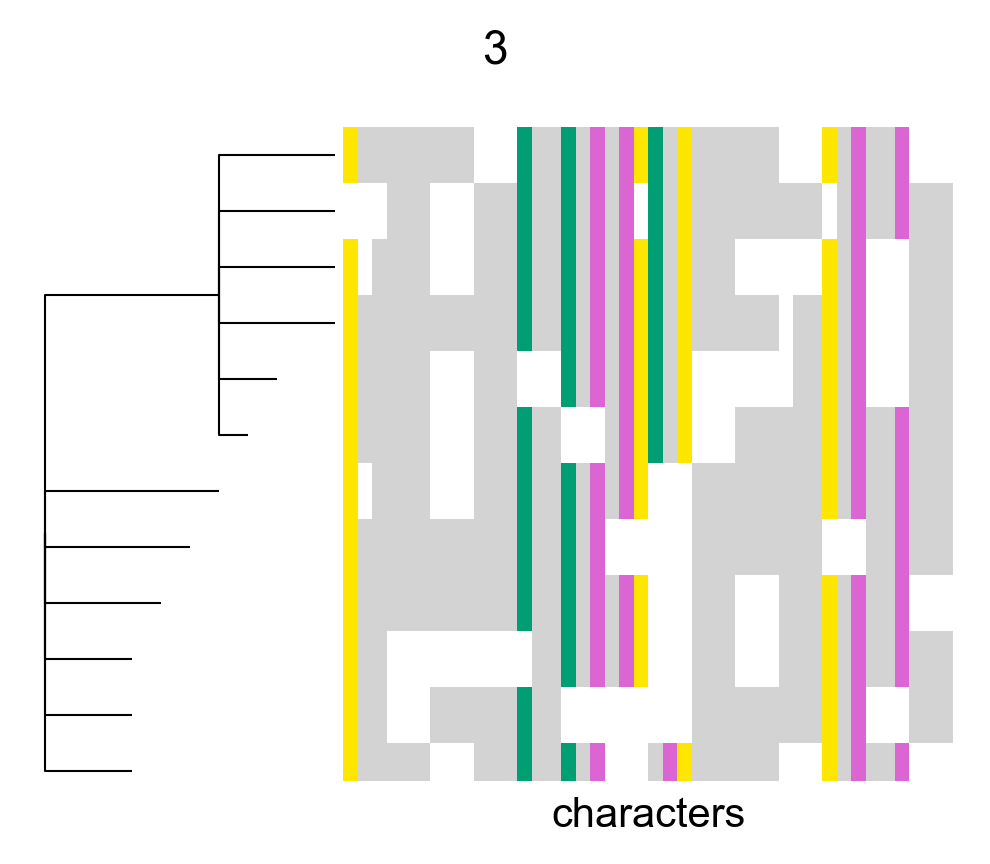

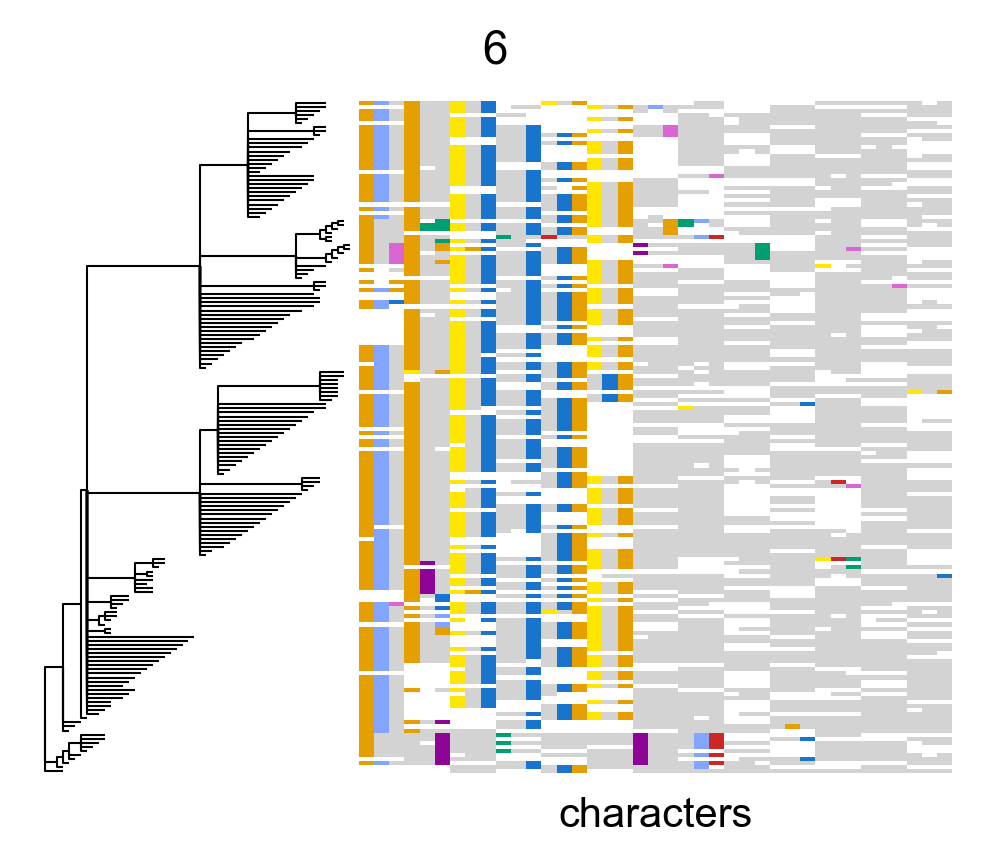

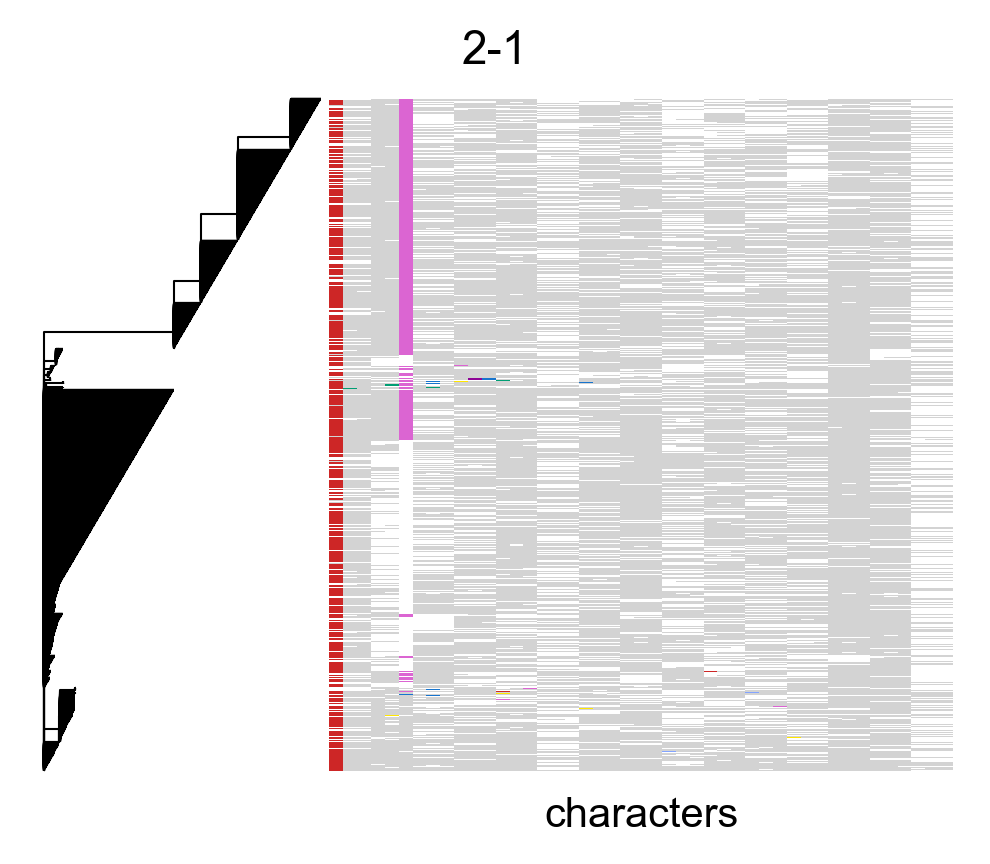

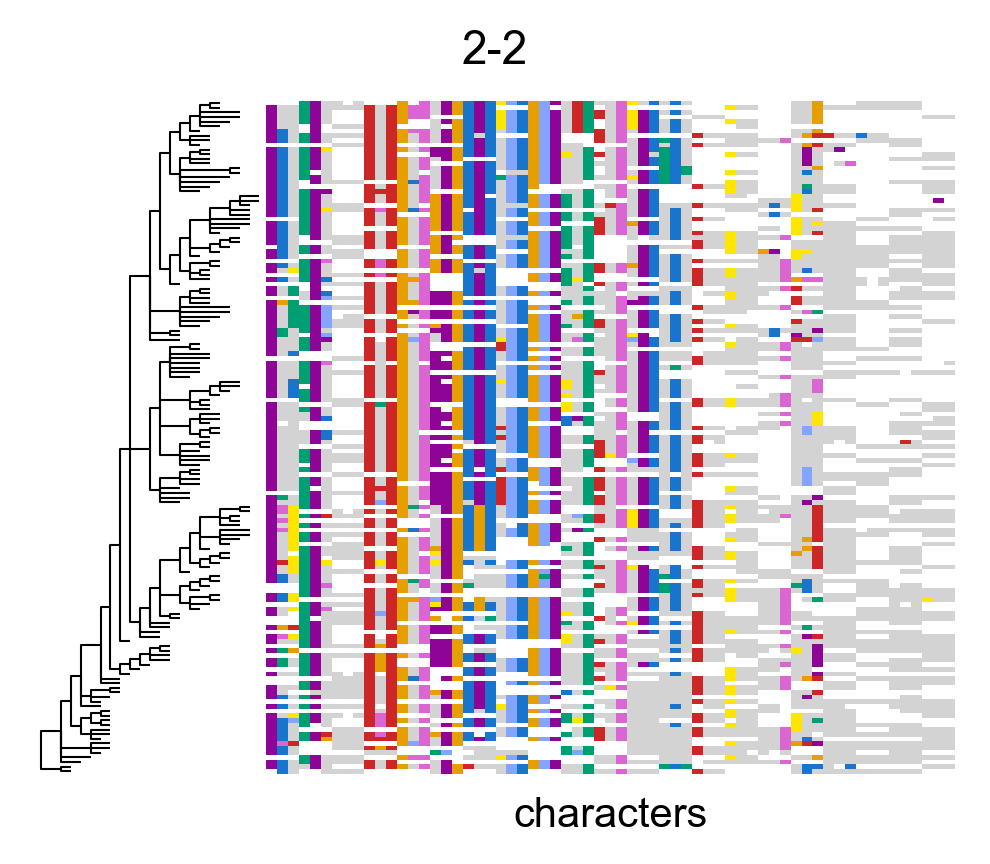

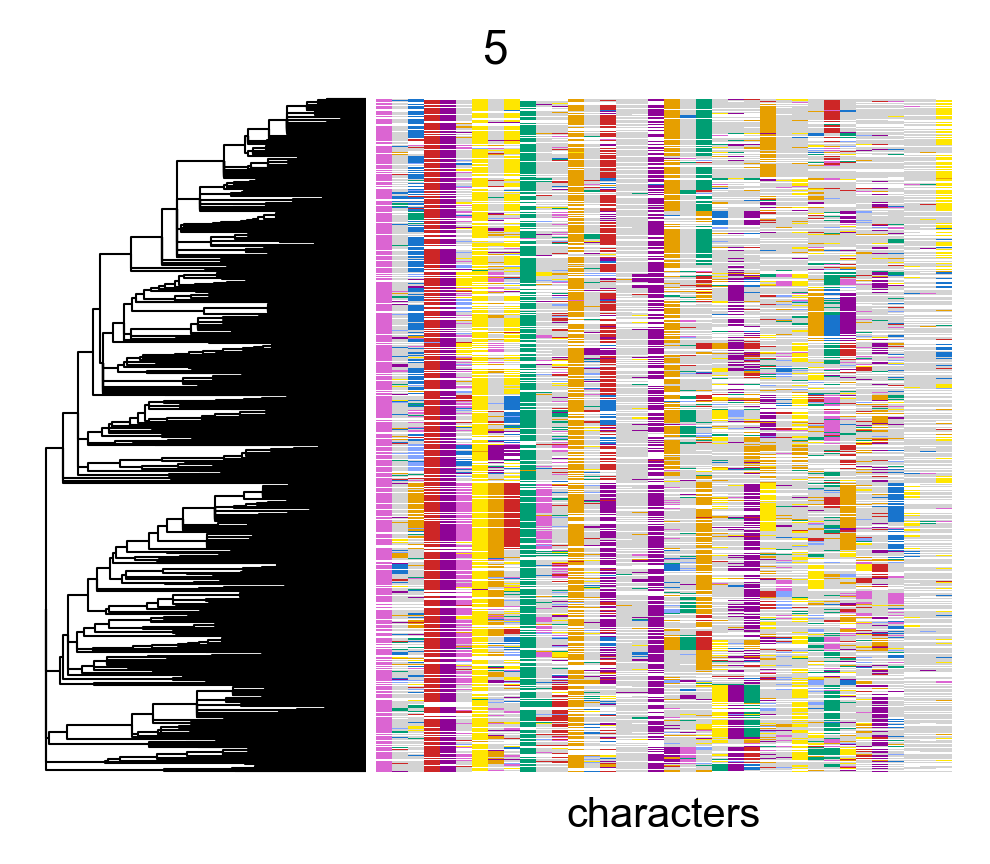

In [78]:
for clone, clone_tdata in clones.items():
    fig, ax = plt.subplots(figsize=(4, 3),dpi = 300)
    py.pl.tree(clone_tdata,keys = "characters",cmap = edit_cmap,depth_key = "time",ax = ax,tree = "nj_collapsed")
    plt.title(clone)

Estimate fitness for clones with good tracing

In [79]:
for clone in ["5"]:
    print("Estimating leaf fitness for clone", clone)
    petracer.tree.petracer.tree.estimate_leaf_fitness(clones[clone], depth_key="time",copy = False,tree = "nj")

Estimating leaf fitness for clone 5
node_ranking: inferring ancestral fitness... done in  34.12 s
node_ranking: calculating alternative rankings... done in  2.3 s


## Clades

In [155]:
clades = {'5':{'node4': '1',
        'node8': '2',
        'node2': '3',
        'node92': '4',
        'node178': '5',
        'node177': '6',
        'node999': '7',
        'node234': '8',
        'node233': '9',
        'node230': '10',
        'node429': '11',
        'node1085':'12',
        'node229': '13',
        'node1344': '14',
        'node1343': '15'}}

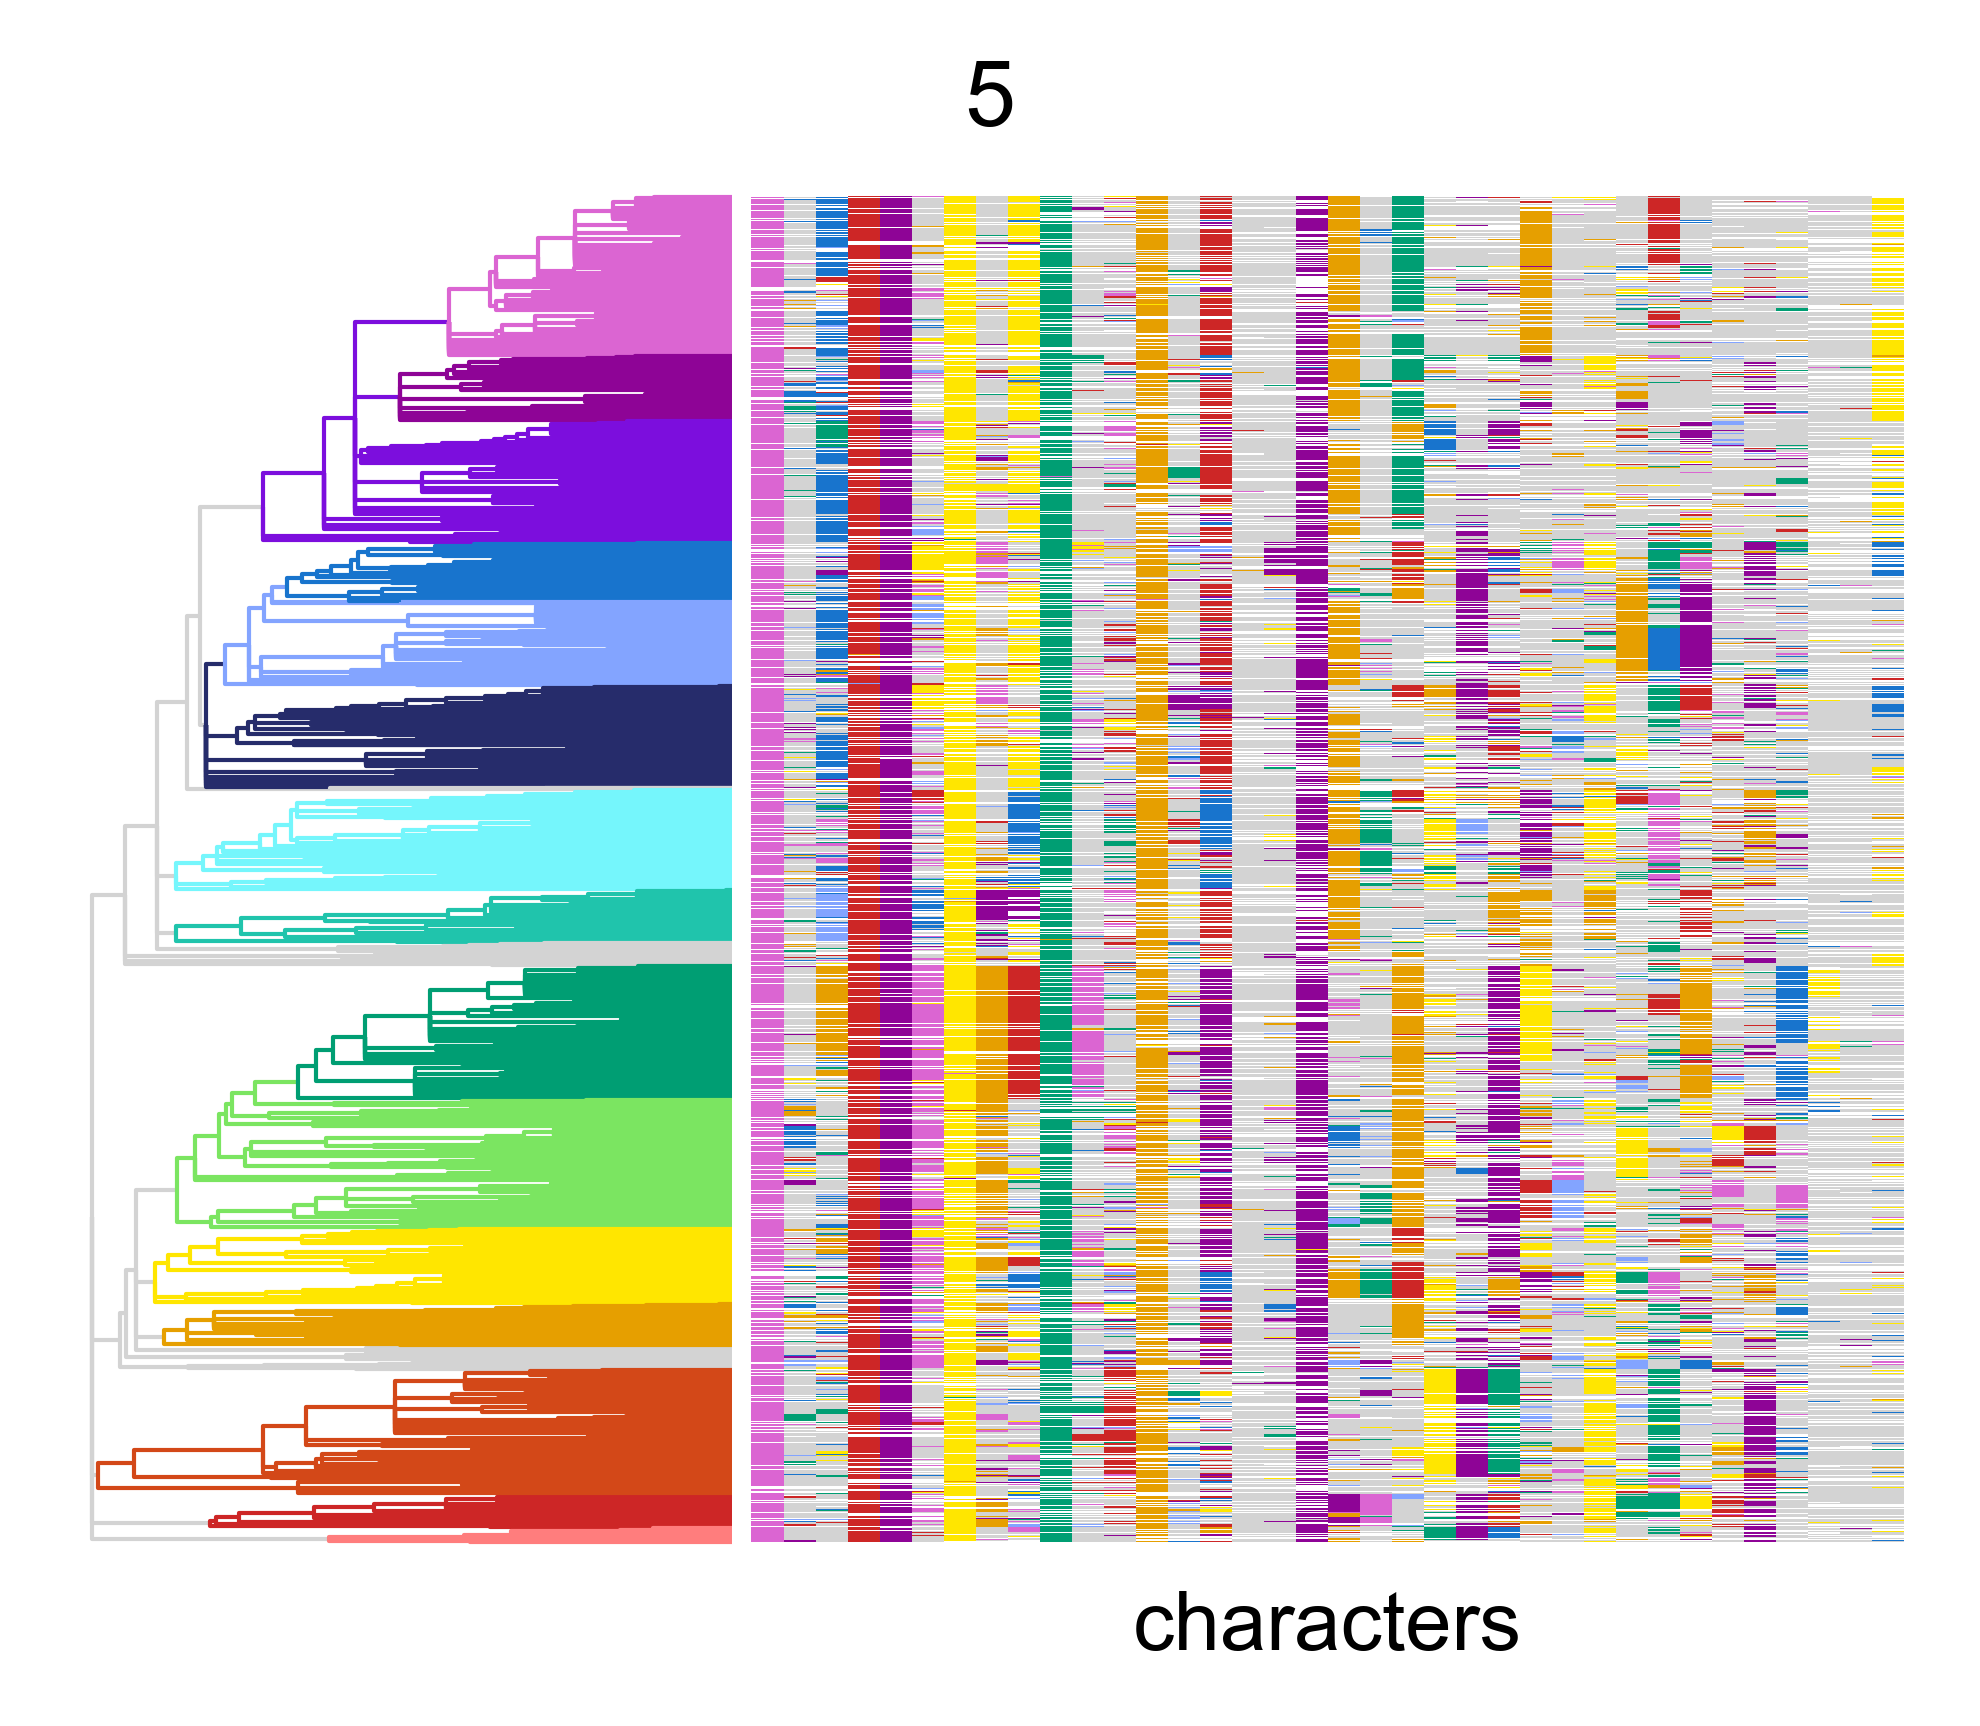

In [156]:
for clone, clades in clades.items():
    py.tl.clades(clones[clone],tree = "nj_collapsed",clades = clades)
    fig, ax = plt.subplots(figsize=(4, 3),dpi = 600)
    unique_clades = sorted(clones[clone].obs["clade"].dropna().unique().astype(int))
    clade_colors = {str(clade): discrete_cmap[len(unique_clades)][i] for i,clade in enumerate(unique_clades)}
    py.pl.branches(clones[clone],color = "clade",palette=clade_colors,depth_key = "time",ax = ax,tree = "nj_collapsed")
    py.pl.annotation(clones[clone],keys = "characters",cmap = edit_cmap)
    plt.title(clone)

## Character dist of relatives

In [ ]:
for clone, clone_tdata in clones.items():
    py.tl.distance(clone_tdata, metric = petracer.tree.hamming_distance, key = "characters",key_added="character")
    clone_tdata.obs["character_dist_of_relatives"] = np.mean(np.partition(clone_tdata.obsp["character_distances"], 20, axis=1)[:, :20], axis=1)

## Local character diversity

In [ ]:
for clone, clone_tdata in clones.items():
    sq.gr.spatial_neighbors(clone_tdata, coord_type="generic", radius=100)
    clone_tdata.obs["local_character_diversity"] = np.nan
    for obs in clone_tdata.obs_names:
        neighbors = clone_tdata.obsp["spatial_connectivities"][clone_tdata.obs_names == obs,:].nonzero()[1]
        if len(neighbors) < 2:
            continue
        apgd = clone_tdata.obsp["character_distances"][neighbors,:][:,neighbors]
        apgd = apgd[np.triu_indices(apgd.shape[0],k=1)].mean()
        clone_tdata.obs.loc[obs,"local_character_diversity"] = apgd

## Write data

Create tdata object with all clones

In [157]:
tdata = td.TreeData(adata.copy(), allow_overlap = True)
tdata.uns["clone_characters"] = {}
characters = []
columns = {"fitness":[],"clade":[],"character_dist_of_relatives":[],"local_character_diversity":[]}
for clone, clone_tdata in clones.items():
    tdata.obst[clone] = clone_tdata.obst["nj"]
    tdata.obst[f"{clone}_collapsed"] = clone_tdata.obst["nj_collapsed"]
    characters.append(clone_tdata.obsm["characters"])
    tdata.uns["clone_characters"][clone] = list(clone_tdata.obsm["characters"].columns.values)
    for column in columns.keys():
        if column in clone_tdata.obs.columns:
            columns[column].append(clone_tdata.obs[column])
characters = pd.concat(characters)
tdata.obsm["characters"] = characters.reindex(tdata.obs_names).fillna("-1").astype(int)
tdata.obs.loc[tdata.obs["tree"].isna() & (tdata.obs["type"] == "tracing"), "type"] = "low_detection"
for column, value in columns.items():
    if value:
        tdata.obs[column] = tdata.obs["cellBC"].map(pd.concat(value))

In [ ]:
tdata.write(data_path / "M2_tumor_tracing.h5td")